In [1]:
# Check if a given function called with given types is type stable
function typestable(@nospecialize(f), @nospecialize(t))
    v = code_typed(f, t)
    stable = true
    for vi in v
        for (name, ty) in zip(vi[1].slotnames, vi[1].slottypes)
            !(ty isa Type) && continue
            if ty === Any
                stable = false
                println("Type instability is detected! the variable is $(name) ::$ty")
            end
        end
    end
    return stable
end

using SparseArrays
using LinearAlgebra
function make_x_plushop(Nx,Ny,BC)
    N = Nx*Ny
    Txhop = spzeros(Int64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            jx = ix + 1
            jy = iy
            if BC == "PBC"
                jx += ifelse(jx > Nx,-Nx,0)
            elseif BC == "OBC"
            else
                error("BC = $BC is not supported")
            end
            if 1 <= jx <= Nx
                j = (jy-1)*Nx + jx
                Txhop[i,j] = 1
            end
        end
    end
    return Txhop
end

function make_x_minushop(Nx,Ny,BC)
    N = Nx*Ny
    Txhop = spzeros(Int64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            jx = ix - 1
            jy = iy
            if BC == "PBC"
                jx += ifelse(jx < 1,Nx,0)
            elseif BC == "OBC"
            else
                error("BC = $BC is not supported")
            end
            if 1 <= jx <= Nx
                j = (jy-1)*Nx + jx
                Txhop[i,j] = 1
            end
        end
    end
    return Txhop
end

function make_y_plushop(Nx,Ny,BC)
    N = Nx*Ny
    Tyhop = spzeros(Int64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            jx = ix 
            jy = iy + 1
            if BC == "PBC"
                jy += ifelse(jy > Ny,-Ny,0)
            elseif BC == "OBC"
            else
                error("BC = $BC is not supported")
            end
            if 1 <= jy <= Ny
                j = (jy-1)*Nx + jx
                Tyhop[i,j] = 1
            end
        end
    end
    return Tyhop
end

function make_y_minushop(Nx,Ny,BC)
    N = Nx*Ny
    Tyhop = spzeros(Int64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            jx = ix 
            jy = iy - 1
            if BC == "PBC"
                jy += ifelse(jy < 1,Ny,0)
            elseif BC == "OBC"
            else
                error("BC = $BC is not supported")
            end
            if 1 <= jy <= Ny
                j = (jy-1)*Nx + jx
                Tyhop[i,j] = 1
            end
        end
    end
    return Tyhop
end

function make_H_normal(Nx,Ny,μ,BC)
    N = Nx*Ny
    Tx_plushop = make_x_plushop(Nx,Ny,BC)
    Tx_minushop = make_x_minushop(Nx,Ny,BC)
    Ty_plushop = make_y_plushop(Nx,Ny,BC)
    Ty_minushop = make_y_minushop(Nx,Ny,BC)
    HN = sparse(I,N,N)*(-μ)
    t = 1.0
    
    HN += -t*(Tx_plushop + Tx_minushop + Ty_plushop + Ty_minushop)
    return HN
end

@assert typestable(make_x_plushop,(Int64,Int64,String))
@assert typestable(make_x_minushop,(Int64,Int64,String))
@assert typestable(make_y_plushop,(Int64,Int64,String))
@assert typestable(make_y_minushop,(Int64,Int64,String))

In [2]:
function make_Δ(Δ)
    Nx,Ny = size(Δ)
    N = Nx*Ny
    Δmat = spzeros(ComplexF64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            Δmat[i,i] = Δ[ix,iy]
        end
    end
    return Δmat
end
@assert typestable(make_Δ,(Matrix{ComplexF64},))

In [3]:
function make_H_sc(Nx,Ny,μ,Δ,BC)
    HN = make_H_normal(Nx,Ny,μ,BC)
    matΔ = make_Δ(Δ)
    H = [
        HN matΔ
        matΔ' -conj.(HN)
    ]
    return H
end
@assert typestable(make_H_sc,(Int64,Int64,Float64,Matrix{ComplexF64},String))

In [4]:
function update_H_sc!(H,Δ)
    matΔ = make_Δ(Δ)
    Nx,Ny = size(Δ)
    N = Nx*Ny
    H[1:N,1+N:2N] = matΔ
    H[1+N:2N,1:N] = matΔ'
end

@assert typestable(update_H_sc!,(AbstractMatrix{ComplexF64},Matrix{ComplexF64}))

In [5]:
function calc_ωn(T,ωc)
    M = Int((round(ωc/(T*π)))/2-1)
    println("num. of Matsubara freq: ",2M)
    ωn = zeros(ComplexF64,2M)
    for n=1:2M
        ωn[n] = π*T*(2.0*(n-M-1)+1)*im
    end
    return ωn
end
@assert typestable(calc_ωn,(Float64,Float64))

In [6]:
ωc = 100π
T = 0.01
ωn =  calc_ωn(T,ωc)

num. of Matsubara freq: 9998


9998-element Vector{ComplexF64}:
 -0.0 - 314.06501757937167im
 -0.0 - 314.00218572629984im
 -0.0 - 313.9393538732281im
 -0.0 - 313.87652202015624im
 -0.0 - 313.8136901670845im
 -0.0 - 313.75085831401265im
 -0.0 - 313.6880264609409im
 -0.0 - 313.62519460786905im
 -0.0 - 313.5623627547973im
 -0.0 - 313.4995309017255im
 -0.0 - 313.4366990486537im
 -0.0 - 313.3738671955819im
 -0.0 - 313.3110353425101im
      ⋮
  0.0 + 313.3738671955819im
  0.0 + 313.4366990486537im
  0.0 + 313.4995309017255im
  0.0 + 313.5623627547973im
  0.0 + 313.62519460786905im
  0.0 + 313.6880264609409im
  0.0 + 313.75085831401265im
  0.0 + 313.8136901670845im
  0.0 + 313.87652202015624im
  0.0 + 313.9393538732281im
  0.0 + 314.00218572629984im
  0.0 + 314.06501757937167im

In [7]:
using Pkg
Pkg.add(PackageSpec(name="RSCG", version = "0.1.2"))
using RSCG

   Resolving 

package versions...


  No Changes to `~/git/sparse-ir-tutorial-v2/Project.toml`
  No Changes to `~/git/sparse-ir-tutorial-v2/Manifest.toml`


In [8]:
function calc_Δi!(i,N,H,Δold,T,U,ωn;mixratio = 0.5)
    j = i + N
    Gij = greensfunctions(i,j,ωn,H)
    Δi = U*T*sum(Gij)
    Δi = (1-mixratio)*Δold[i] + mixratio*Δi
    return Δi
end

@assert typestable(calc_Δi!,(Int64,Int64,AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,Float64,Vector{ComplexF64}))

function calc_Δ!(Δnew,H,Δold,T,U,ωn;mixratio = 0.5)
    Nx,Ny = size(Δold)
    N = Nx*Ny
    map!(i -> calc_Δi!(i,N,H,Δold,T,U,ωn,mixratio = mixratio),Δnew,1:N) #If you use pmap! instead of map!, you can do the parallel computation.
    return
end

@assert typestable(calc_Δi!,(AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,Float64,Vector{ComplexF64}))

In [9]:
Nx = 8
Ny = 8
Δ = ones(ComplexF64,Nx,Ny)
Δold = copy(Δ)
Δnew = zero(Δ)
BC = "OBC" #open boundary condition
#BC = "PBC" #periodic boundary condition
U  =-2
μ = -0.2

H = make_H_sc(Nx,Ny,μ,Δ,BC)

128×128 SparseMatrixCSC{ComplexF64, Int64} with 704 stored entries:
⎡⠻⣦⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠢⡈⠱⣦⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠈⠢⡈⠛⣤⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠈⠢⡈⠻⢆⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠢⡈⠻⣦⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠑⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠻⣦⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠱⣦⡈⠦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡌⠛⣤⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠻⢆⡈⠢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠱⢄⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠻⣦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⣄⎥
⎢⠙⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠻⣦⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠢⡈⠱⣦⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠛⣤⡘⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠲⡈⠻⢆⡈⠢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠻⣦⠈⠢⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡀⠻⣦⡈⠢⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠱⣦⡈⠢⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠛⣤⡈⠢⡀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠻⢆⡈⠢⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠢⡈⠻⣦⎦

In [10]:
itemax = 100
ix = Nx ÷ 2
iy = Ny ÷ 2
for ite = 1:itemax
    calc_Δ!(Δnew,H,Δold,T,U,ωn)
    update_H_sc!(H,Δnew)
    eps = sum(abs.(Δnew-Δold))/sum(abs.(Δold))
    println("$ite $eps ",Δnew[ix,iy])
    Δold .= Δnew
    if eps < 1e-3
        break
    end
end

1 0.19022941762000992 0.8018647273863396

 + 0.0im
2 0.15123443512919904 0.6746530178514629

 - 2.3822801641527196e-24im
3 0.11957204967844119 0.5895968165028789

 - 9.264422860593909e-25im
4 0.09424713671714291 0.5308635482893075

 + 5.459392042849983e-23im
5 0.07417362018432204 0.48926475752578036

 + 2.6502866826199006e-23im
6 0.05834519701529431 0.45920813141140293

 + 1.5104317985218284e-23im
7 0.04589794508748614 0.43714686078188003

 + 7.560430798734672e-24im
8 0.036120643666757705 0.4207510020608361

 + 3.664410113609912e-24im
9 0.028441879804335525 0.40844387391119713

 + 1.8404768629304863e-24im
10 0.02240902621519642 0.3991317058041708

 + 9.864128804694854e-25im
11 0.01766625759383746 0.3920398696544636

 + 5.345654708623941e-25im
12 0.013934919941645715 0.3866102770705371

 + 2.3005960786631083e-25im
13 0.010997079359030933 0.3824351090689762

 + 1.4811702843527653e-25im
14 0.008682347181965122 0.3792128458896108

 + 7.638495969044365e-26im
15 0.006857389841360505 0.3767183898795094

 + 4.853223750213467e-26im
16 0.005417744999933703 0.3747823455324858

 + 2.4266118751067335e-26im
17 0.004281512212918361 0.37327637581701256

 + 1.11394732881897e-25im
18 0.0033843551841846284 0.37210271079216084

 - 2.7020694814354275e-26im
19 0.002675705746223044 0.37118651528923285

 + 2.846281890223059e-21im
20 0.002115793595015948 0.37047026911794667

 - 3.747268230315801e-20im
21 0.001673285463285469 0.3699096276296959

 + 5.799565548531724e-19im
22 0.0013234787085562852 0.3694702985636299

 - 1.3454338608093842e-19im
23 0.0010469154220813022 0.36912567318688794

 - 9.641809675548968e-20im
24 0.0008282074675309601 0.3688551218644004

 - 4.8873638369094447e-20im


In [11]:
using SparseIR
import SparseIR: valueim

wmax = 10.0
beta = 1/T
basis = FiniteTempBasis(Fermionic(), beta, wmax, 1e-7)
smpl = MatsubaraSampling(basis)
ωn_s = valueim.(smpl.sampling_points, beta)
println("num. of Matsubara freqs. ", length(ωn_s))
smpl_beta = TauSampling(basis; sampling_points=[beta])


num. of Matsubara freqs. 40

TauSampling{Float64, FiniteTempBasis{Fermionic, LogisticKernel}} with sampling points:
 100.0

In [12]:
function fit_ir(Gij,smpl_Matsubara,smpl_beta)
    gl = fit(smpl_Matsubara, Gij)
    G0 = evaluate(smpl_beta, gl)
    return -G0[1]
end

@assert typestable(fit_ir,(Vector{ComplexF64},typeof(smpl),typeof(smpl_beta)))

function calc_Δi_ir!(i,N,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta;mixratio = 0.5)
    j = i + N
    Gij = greensfunctions(i,j,ωn,H)
    G0 = fit_ir(Gij,smpl_Matsubara,smpl_beta)
    Δi = U*G0
    Δi = (1-mixratio)*Δold[i] + mixratio*Δi
    return Δi
end

@assert typestable(calc_Δi_ir!,(Int64,Int64,AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,
            Float64,Vector{ComplexF64},typeof(smpl),typeof(smpl_beta)))


function calc_Δ_ir!(Δnew,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta;mixratio = 0.5)
    Nx,Ny = size(Δold)
    N = Nx*Ny
    map!(i -> calc_Δi_ir!(i,N,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta,mixratio = mixratio),Δnew,1:N) #If you use pmap! instead of map!, you can do the parallel computation.
    return
end

@assert typestable(calc_Δ_ir!,(Matrix{ComplexF64},AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,
            Float64,Vector{ComplexF64},typeof(smpl),typeof(smpl_beta)))

In [13]:
Nx = 8
Ny = 8
Δ = ones(ComplexF64,Nx,Ny)
Δold = copy(Δ)
Δnew = zero(Δ)
BC = "OBC" #open boundary condition
#BC = "PBC" #periodic boundary condition
U  =-2
μ = -0.2

H = make_H_sc(Nx,Ny,μ,Δ,BC)

for ite = 1:itemax
    calc_Δ_ir!(Δnew,H,Δold,T,U,ωn_s,smpl,smpl_beta)
    update_H_sc!(H,Δnew)

    eps = sum(abs.(Δnew-Δold))/sum(abs.(Δold))
    println("$ite $eps ",Δnew[ix,iy])
    Δold .= Δnew
    if eps < 1e-4
        break
    end
end

1 0.18921615164848435 0.8028780014466959

 + 0.0im
2 0.15045798089955517 0.67613265232365 + 0.0im
3 0.11898342155041434 0.5912904830148455 + 0.0im
4 0.09380324372432211 0.532650623356926 + 0.0im
5 0.07383910014788153 0.49108666439842313 + 0.0im
6 0.05809241626039358 0.4610366148445454

 + 0.0im
7 0.04570607035884867 0.43896894741955167 + 0.0im
8 0.035974258239247374 0.42256139576894436 + 0.0im
9 0.02832963102289301 0.4102411664667658 + 0.0im
10 0.022322528528486617 0.40091636495141914

 + 0.0im
11 0.017599330194407178 0.39381319052763464 + 0.0im
12 0.013882928308046832 0.3883738342014772 + 0.0im
13 0.010956577494653594 0.3841904789916768 + 0.0im
14 0.008650701712150126 0.3809614747586631

 + 0.0im
15 0.006832615137502494 0.3784615438673522 + 0.0im
16 0.00539832867321752 0.37652109592453376 + 0.0im
17 0.004266248769011665 0.3750116132193547 + 0.0im
18 0.0033723569497473827 0.373835157118076

 + 0.0im
19 0.002666274184818875 0.37291675348099756 + 0.0im
20 0.0021083661522698833 0.3721987781677325 + 0.0im
21 0.0016674326251606864 0.37163677642134507 + 0.0im
22 0.001318868482202711 0.37119638674079797

 + 0.0im
23 0.001043279630462665 0.3708509437459749 + 0.0im
24 0.0008253422224984762 0.37057974279209943 + 0.0im
25 0.0006529826535987726 0.3703666607922932 + 0.0im
26 0.0005166477021524091 0.3701991250949024

 + 0.0im
27 0.0004088042723344111 0.3700673179185307 + 0.0im
28 0.0003234857619323327 0.36996355941136116 + 0.0im
29 0.00025598063083884904 0.36988183949532116 + 0.0im
30 0.0002025800306332068 0.3698174398474263

 + 0.0im
31 0.0001603145372594379 0.36976668098945864 + 0.0im
32 0.00012687045254221408 0.36972665282447603 + 0.0im
33 0.00010040660125685253 0.3696950714296857 + 0.0im
34 7.94693795787508e-5 0.369670154310769

 + 0.0im


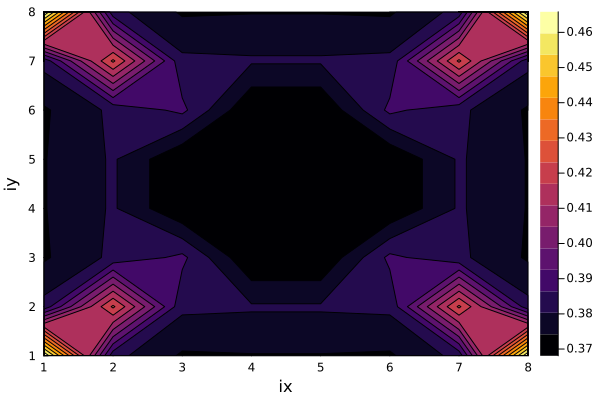

In [14]:
using Plots
plot(1:Nx,1:Ny,abs.(Δnew),st=:contourf,
    xlabel = "ix",
    ylabel = "iy",
    zlabel = "|Delta|")

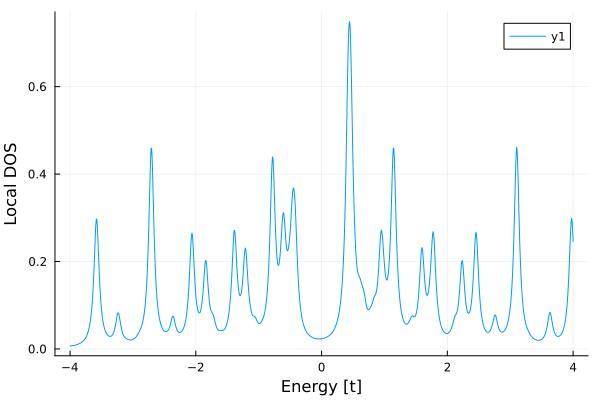

In [15]:
M = 1000
σ = zeros(ComplexF64,M)
η = 0.05
σmin = -4.0 + im*η
σmax = 4.0+ im*η
for i=1:M
    σ[i] = (i-1)*(σmax-σmin)/(M-1) + σmin
end

i = (iy-1)*Nx + ix
j = i

Gij1 = greensfunctions(i,j,σ,H) 
plot(real.(σ),(-1/π)*imag.(Gij1),
    xlabel = "Energy [t]",
    ylabel = "Local DOS",)


In [16]:
const σ0 = [1 0
0 1]
const σx = [0 1
1 0]
const σy = [0 -im
im 0]
const σz = [1 0
0 -1]

2×2 Matrix{Int64}:
 1   0
 0  -1

In [17]:
function make_Htsc_normal(Nx,Ny,μ,BC,h,α)
    N = Nx*Ny
    Tx_plushop = make_x_plushop(Nx,Ny,BC)
    Tx_minushop = make_x_minushop(Nx,Ny,BC)
    Ty_plushop = make_y_plushop(Nx,Ny,BC)
    Ty_minushop = make_y_minushop(Nx,Ny,BC)
    HN = kron(sparse(I,N,N)*(-μ),σ0) 
    HN += kron(sparse(I,N,N)*(-h),σz) #Zeeman magnetic field
    t = 1.0
    
    HN += kron(-t*(Tx_plushop + Tx_minushop + Ty_plushop + Ty_minushop),σ0)
    
    Hax = kron((α/(2im))*(Tx_plushop - Tx_minushop ) ,σy)
    HN += Hax 
    Hay = kron((α/(2im))*(Ty_plushop - Ty_minushop ) ,σx)
    HN += Hay 
    
    return HN
end

@assert typestable(make_Htsc_normal,(Int64,Int64,Float64,String,Float64,Float64))

In [18]:
function make_Δtsc(Δ)
    Nx,Ny = size(Δ)
    N = Nx*Ny
    Δmat = spzeros(ComplexF64,N,N)
    for ix=1:Nx
        for iy=1:Ny
            i = (iy-1)*Nx + ix
            Δmat[i,i] = Δ[ix,iy]
        end
    end
    return kron(Δmat,im*σy)
end

@assert typestable(make_Δtsc,(Matrix{ComplexF64},))

In [19]:
function make_Htsc_sc(Nx,Ny,μ,Δ,BC,h,α)
    HN = make_Htsc_normal(Nx,Ny,μ,BC,h,α)
    matΔ = make_Δtsc(Δ)
    H = [
        HN matΔ
        matΔ' -conj.(HN)
    ]
    return H
end

@assert typestable( make_Htsc_sc,(Int64,Int64,Float64,Matrix{ComplexF64},String,Float64,Float64))

In [20]:
function update_Htsc_sc!(H,Δ)
    matΔ = make_Δtsc(Δ)
    N,_ = size(matΔ)
    H[1:N,1+N:2N] = matΔ
    H[1+N:2N,1:N] = matΔ'
end

@assert typestable(update_Htsc_sc!,(AbstractMatrix{ComplexF64},Matrix{ComplexF64}))

In [21]:
function calc_Δitsc_ir!(i,N,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta;mixratio = 0.5)
    ispin = 1
    ii = (i-1)*2 + ispin
    jspin = 2
    jj = (i-1)*2 + jspin + N
    
    Gij = greensfunctions(ii,jj,ωn,H) 
    G0 = fit_ir(Gij,smpl_Matsubara,smpl_beta)            
    Δi = U*G0
    Δi = (1-mixratio)*Δold[i] + mixratio*Δi   
    return Δi
end

@assert typestable(calc_Δitsc_ir!,(Int64,Int64,AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,
            Float64,Vector{ComplexF64},typeof(smpl),typeof(smpl_beta)))


function calc_Δtsc_ir!(Δnew,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta,;mixratio = 0.5)
    Nx,Ny = size(Δold)
    N = Nx*Ny*2
    map!(i -> calc_Δitsc_ir!(i,N,H,Δold,T,U,ωn,smpl_Matsubara,smpl_beta,mixratio = mixratio),Δnew,1:Nx*Ny) #If you use pmap! instead of map!, you can do the parallel computation.
end

@assert typestable(calc_Δtsc_ir!,(Matrix{ComplexF64},AbstractMatrix{ComplexF64},Matrix{ComplexF64},Float64,
            Float64,Vector{ComplexF64},typeof(smpl),typeof(smpl_beta)))

In [22]:
T = 0.01

beta = 1/T
wmax = 10.0

basis = FiniteTempBasis(Fermionic(), beta, wmax, 1e-5)
smpl = MatsubaraSampling(basis)
ωn = valueim.(smpl.sampling_points, beta)
println("num. of Matsubara freqs. ", length(ωn))
smpl_beta = TauSampling(basis; sampling_points=[beta])

U  =-5.6
itemax = 1000
μ = 3.5

Nx = 16
Ny = 16
Δ = 3*ones(ComplexF64,Nx,Ny)
Δold = copy(Δ)
Δnew = zero(Δ)
BC = "OBC"
h = 1
α = 1
Htsc =  make_Htsc_sc(Nx,Ny,μ,Δold,BC,h,α)

ix = Nx ÷ 2
iy = Ny ÷ 2
i = (iy-1)*Nx + ix
j = i


for ite = 1:itemax
    calc_Δtsc_ir!(Δnew,Htsc,Δold,T,U,ωn,smpl,smpl_beta,mixratio =1)
    update_Htsc_sc!(Htsc,Δnew)

    eps = sum(abs.(Δnew-Δold))/sum(abs.(Δold))
    println("$ite $eps ",Δnew[ix,iy]," ave: ",sum(abs.(Δnew))/length(Δnew))

    Δold .= Δnew
    if eps < 1e-2
        break
    end
end

num. of Matsubara freqs. 30


1 0.3728272016235052 

1.8802286089278162 + 0.0im ave: 1.881518395129485
2 0.2096507194224921 

1.4861198674306593 + 0.0im ave: 1.4870567099839358
3 0.13563810810706642 

1.2830170512980985 + 0.0im ave: 1.2853551511937957
4 0.09725164601108567 

1.1552868424541933 + 0.0im ave: 1.1603522470313712
5 0.07520775591249981 

1.0644744086013658 + 0.0im ave: 1.073084758464115
6 0.06140200383584062 

0.9944949176500074 + 0.0im ave: 1.0071952040087195
7 0.05208813121543048 

0.9375699379474195 + 0.0im ave: 0.9547322880627609
8 0.04536878281536442 

0.889596547363097 + 0.0im ave: 0.9114172462388256
9 0.04020717833270542 

0.8482988464617984 + 0.0im ave: 0.8747717304837979
10 0.03600997191666685 

0.8123559752647257 + 0.0im ave: 0.8432712250355824
11 0.03243429015676177 

0.7809415821795211 + 0.0im ave: 0.8159203214419304
12 0.029285626881851587 

0.7534748748720559 + 0.0im ave: 0.7920255833428614
13 0.026456611312423474 

0.7294936160240606 + 0.0im ave: 0.7710712703348639
14 0.023888650824608247 

0.7085963647209356 + 0.0im ave: 0.7526514179969473
15 0.021548660591477652 

0.6904201918694225 + 0.0im ave: 0.7364327880468368
16 0.019415840736352257 

0.6746341382511649 + 0.0im ave: 0.7221343263210913
17 0.01747475928393635 

0.6609380833301545 + 0.0im ave: 0.7095152027979628
18 0.01571206789031308 

0.6490626244860312 + 0.0im ave: 0.6983672517623919
19 0.014115111841861577 

0.63876839591797 + 0.0im ave: 0.6885097198970724
20 0.012671475898475405 

0.6298445740968737 + 0.0im ave: 0.6797852855755305
21 0.011368961360685246 

0.6221067301533081 + 0.0im ave: 0.67205683293026
22 0.010195716771536049 

0.6153943869394549 + 0.0im ave: 0.6652047318073275
23 0.009140354197562992 

0.6095684028937481 + 0.0im ave: 0.6591245249447136


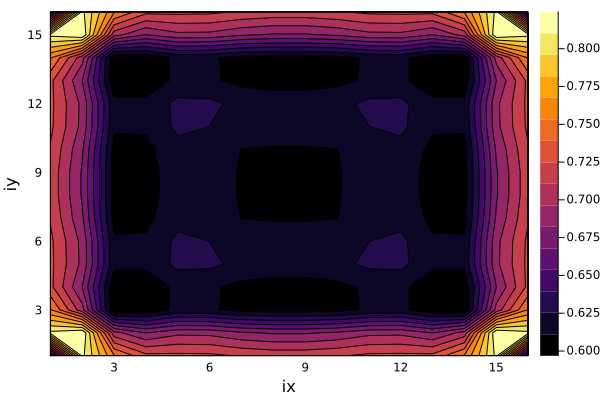

In [23]:
using Plots
plot(1:Nx,1:Ny,abs.(Δnew),st=:contourf,
    xlabel = "ix",
    ylabel = "iy",
    zlabel = "|Delta|")

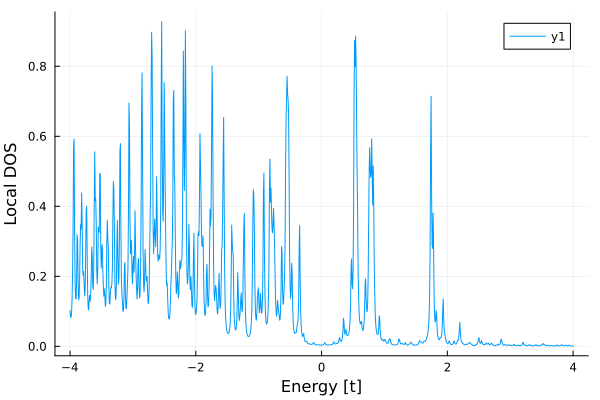

In [24]:
using Plots
M = 1000
σ = zeros(ComplexF64,M)
η = 0.01
σmin = -4.0 + im*η
σmax = 4.0+ im*η
for i=1:M
    σ[i] = (i-1)*(σmax-σmin)/(M-1) + σmin
end


ix = Nx ÷ 2
iy = Ny ÷ 2
ispin  =1

i = (( iy-1)*Nx + ix-1)*2 + ispin
j = i
Gij1 = greensfunctions(i,j,σ,Htsc) 

ispin  =2
i = (( iy-1)*Nx + ix-1)*2 + ispin
j = i
Gij2 = greensfunctions(i,j,σ,Htsc) 
plot(real.(σ),(-1/π)*imag.(Gij1 .+ Gij2),
    xlabel = "Energy [t]",
    ylabel = "Local DOS",)


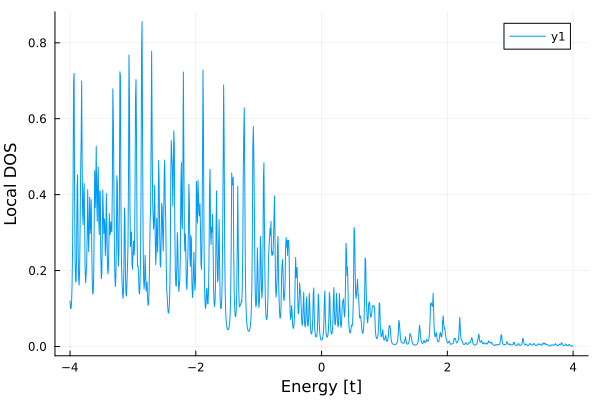

In [25]:
ix = 1
iy = Ny ÷ 2
ispin  =1

i = (( iy-1)*Nx + ix-1)*2 + ispin
j = i
Gij1 = greensfunctions(i,j,σ,Htsc) 

ispin  =2
i = (( iy-1)*Nx + ix-1)*2 + ispin
j = i
Gij2 = greensfunctions(i,j,σ,Htsc) 
plot(real.(σ),(-1/π)*imag.(Gij1 .+ Gij2),
    xlabel = "Energy [t]",
    ylabel = "Local DOS",)